Question: Will adjusted closing price for Apple go up or down the next day?

In [239]:
import pandas as pd 
import datetime as dt
import yfinance as yf
from finta import TA
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout

In [210]:
apple = yf.Ticker("AAPL")
# apple_hist = apple.history(period="max")
date_from = str(dt.date.today() - dt.timedelta(days=10000))
date_to = str(dt.date.today())

print(f'Downloading Apple stock data from {date_from} to {date_to}.')
apple_hist = yf.download("AAPL", start=date_from, end=date_to)

apple_hist.rename(columns={"Close": 'close', "High": 'high', "Low": 'low', 'Volume': 'volume', 'Open': 'open'}, inplace=True)
apple_hist.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,Adj Close,volume
Date,,,,,,
1996-01-29,0.258929,0.265625,0.256696,0.260045,0.221023,332595200
1996-01-30,0.241071,0.251116,0.239816,0.243862,0.207269,622843200
1996-01-31,0.247768,0.250000,0.244420,0.246652,0.209640,328059200
1996-02-01,0.245536,0.253348,0.245536,0.253348,0.215331,333043200
1996-02-02,0.257813,0.264509,0.256696,0.261161,0.221972,555979200


In [211]:
def get_tranformations(data):
    data['log_close'] = np.log(data['close']/data['close'].shift(1))
    data['log_vol'] = np.log(data['volume']/data['volume'].shift(1))
    return data

In [151]:
def get_technical_indcators(data, indicators):
    for indicator in indicators:
        ind_data = eval('TA.' + indicator + '(data)')
        if not isinstance(ind_data, pd.DataFrame):
            ind_data = ind_data.to_frame()
        data = data.merge(ind_data, left_index=True, right_index=True)

    data['ema50'] = data['close'] / data['close'].ewm(50).mean()
    data['ema25'] = data['close'] / data['close'].ewm(25).mean()
    data['ema15'] = data['close'] / data['close'].ewm(12).mean()
    data['ema5'] = data['close'] / data['close'].ewm(5).mean()

    data['normvol'] = data['volume'] / data['volume'].ewm(5).mean()

    del (data['open'])
    del (data['high'])
    del (data['low'])
    del (data['volume'])
    del (data['Adj Close'])
    # del (data['Dividends'])
    # del (data['Stock Splits'])

    return data

In [212]:
tranformed_data = get_tranformations(apple_hist)
tranformed_data

,open,high,low,close,Adj Close,volume,log_close,log_vol
Date,,,,,,,,
1996-01-29,0.258929,0.265625,0.256696,0.260045,0.221023,332595200,NaN,NaN
1996-01-30,0.241071,0.251116,0.239816,0.243862,0.207269,622843200,-0.064252,0.627369
1996-01-31,0.247768,0.250000,0.244420,0.246652,0.209640,328059200,0.011376,-0.641101
1996-02-01,0.245536,0.253348,0.245536,0.253348,0.215331,333043200,0.026786,0.015078
1996-02-02,0.257813,0.264509,0.256696,0.261161,0.221972,555979200,0.030373,0.512459
...,...,...,...,...,...,...,...,...
2023-06-08,177.899994,180.839996,177.460007,180.570007,180.570007,50214900,0.015347,-0.209929
2023-06-09,181.500000,182.229996,180.630005,180.960007,180.960007,48870700,0.002157,-0.027134
2023-06-12,181.270004,183.889999,180.970001,183.789993,183.789993,54274900,0.015518,0.104884


In [213]:
INDICATORS = ['RSI', 'MACD', 'STOCH', 'BBANDS']
stock_data = get_technical_indcators(tranformed_data, INDICATORS)
stock_data.head()

,close,log_close,log_vol,14 period RSI,MACD,SIGNAL,14 period STOCH %K,BB_UPPER,BB_MIDDLE,BB_LOWER,ema50,ema25,ema15,ema5,normvol
Date,,,,,,,,,,,,,,,
1996-01-29,0.260045,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
1996-01-30,0.243862,-0.064252,0.627369,0.000000,-0.000363,-0.000202,NaN,NaN,NaN,NaN,0.968193,0.968495,0.969130,0.970719,1.268746
1996-01-31,0.246652,0.011376,-0.641101,15.659167,-0.000376,-0.000273,NaN,NaN,NaN,NaN,0.986220,0.986557,0.987255,0.988936,0.769213
1996-02-01,0.253348,0.026786,0.015078,39.959306,-0.000131,-0.000225,NaN,NaN,NaN,NaN,1.009616,1.009772,1.010070,1.010648,0.840155
1996-02-02,0.261161,0.030373,0.512459,55.918624,0.000316,-0.000064,NaN,NaN,NaN,NaN,1.032004,1.031794,1.031305,1.029816,1.261091


In [196]:
def get_ground_truth(data):
    y = (data.shift(-1)['close'] >= data['close'])
    y = y.iloc[:-1]
    data['y'] = y.astype(int)
    return data

In [214]:
Xy = get_ground_truth(stock_data)
Xy

,close,log_close,log_vol,14 period RSI,MACD,SIGNAL,14 period STOCH %K,BB_UPPER,BB_MIDDLE,BB_LOWER,ema50,ema25,ema15,ema5,normvol,y
Date,,,,,,,,,,,,,,,,
1996-01-29,0.260045,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,1.000000,0.0
1996-01-30,0.243862,-0.064252,0.627369,0.000000,-0.000363,-0.000202,NaN,NaN,NaN,NaN,0.968193,0.968495,0.969130,0.970719,1.268746,1.0
1996-01-31,0.246652,0.011376,-0.641101,15.659167,-0.000376,-0.000273,NaN,NaN,NaN,NaN,0.986220,0.986557,0.987255,0.988936,0.769213,1.0
1996-02-01,0.253348,0.026786,0.015078,39.959306,-0.000131,-0.000225,NaN,NaN,NaN,NaN,1.009616,1.009772,1.010070,1.010648,0.840155,1.0
1996-02-02,0.261161,0.030373,0.512459,55.918624,0.000316,-0.000064,NaN,NaN,NaN,NaN,1.032004,1.031794,1.031305,1.029816,1.261091,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-08,180.570007,0.015347,-0.209929,66.571016,3.008964,2.884819,69.646626,182.074346,175.607502,169.140658,1.108858,1.063850,1.032890,1.015272,0.758077,1.0
2023-06-09,180.960007,0.002157,-0.027134,67.257805,3.052306,2.918317,72.349326,182.792804,175.968002,169.143200,1.108834,1.063442,1.032332,1.014512,0.771501,1.0
2023-06-12,183.789993,0.015518,0.104884,71.787304,3.277234,2.990100,91.961163,183.992427,176.529002,169.065576,1.123395,1.076757,1.044581,1.025187,0.877761,0.0


In [ ]:
# def train_test_split(data, split):
#     train_df = data.iloc[:int(data.shape[0]*split), :]
#     test_df = data.iloc[int(data.shape[0]*split):, :]
    
#     X_train, y_train = []
#     for i in range(20, train_df.shape[0]-step_predict):
#         X_train.append(train_df[i-seq_length+1: i][['close_log']].values)
#         y_train.append(train_df.loc[i-1, 'log_y'])
#         X_train, y_train= np.array(X_train), np.array(y_train)

In [215]:
# Xy = get_ground_truth(stock_data)
# weekly_trend = Xy.shift(1).rolling(7).mean()["y"]
# Xy["weekly_trend"] = weekly_trend
# tranformed_data.dropna(inplace=True)
Xy.dropna(inplace=True)
# tranformed_data.dropna(inplace=True)



In [155]:
# EDA 
import matplotlib.pyplot as plt
import seaborn as sns

def plot_histograms(data):
    data.hist(bins=50, figsize=(20,15), color='darkgreen')
    plt.show()

def plot_corr_heatmap(data):
    fig,ax = plt.subplots(figsize=(20, 20))
    sns.heatmap(data.iloc[:, 0:-1].corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)

In [225]:
Xy = Xy.drop(columns='close', axis=1)

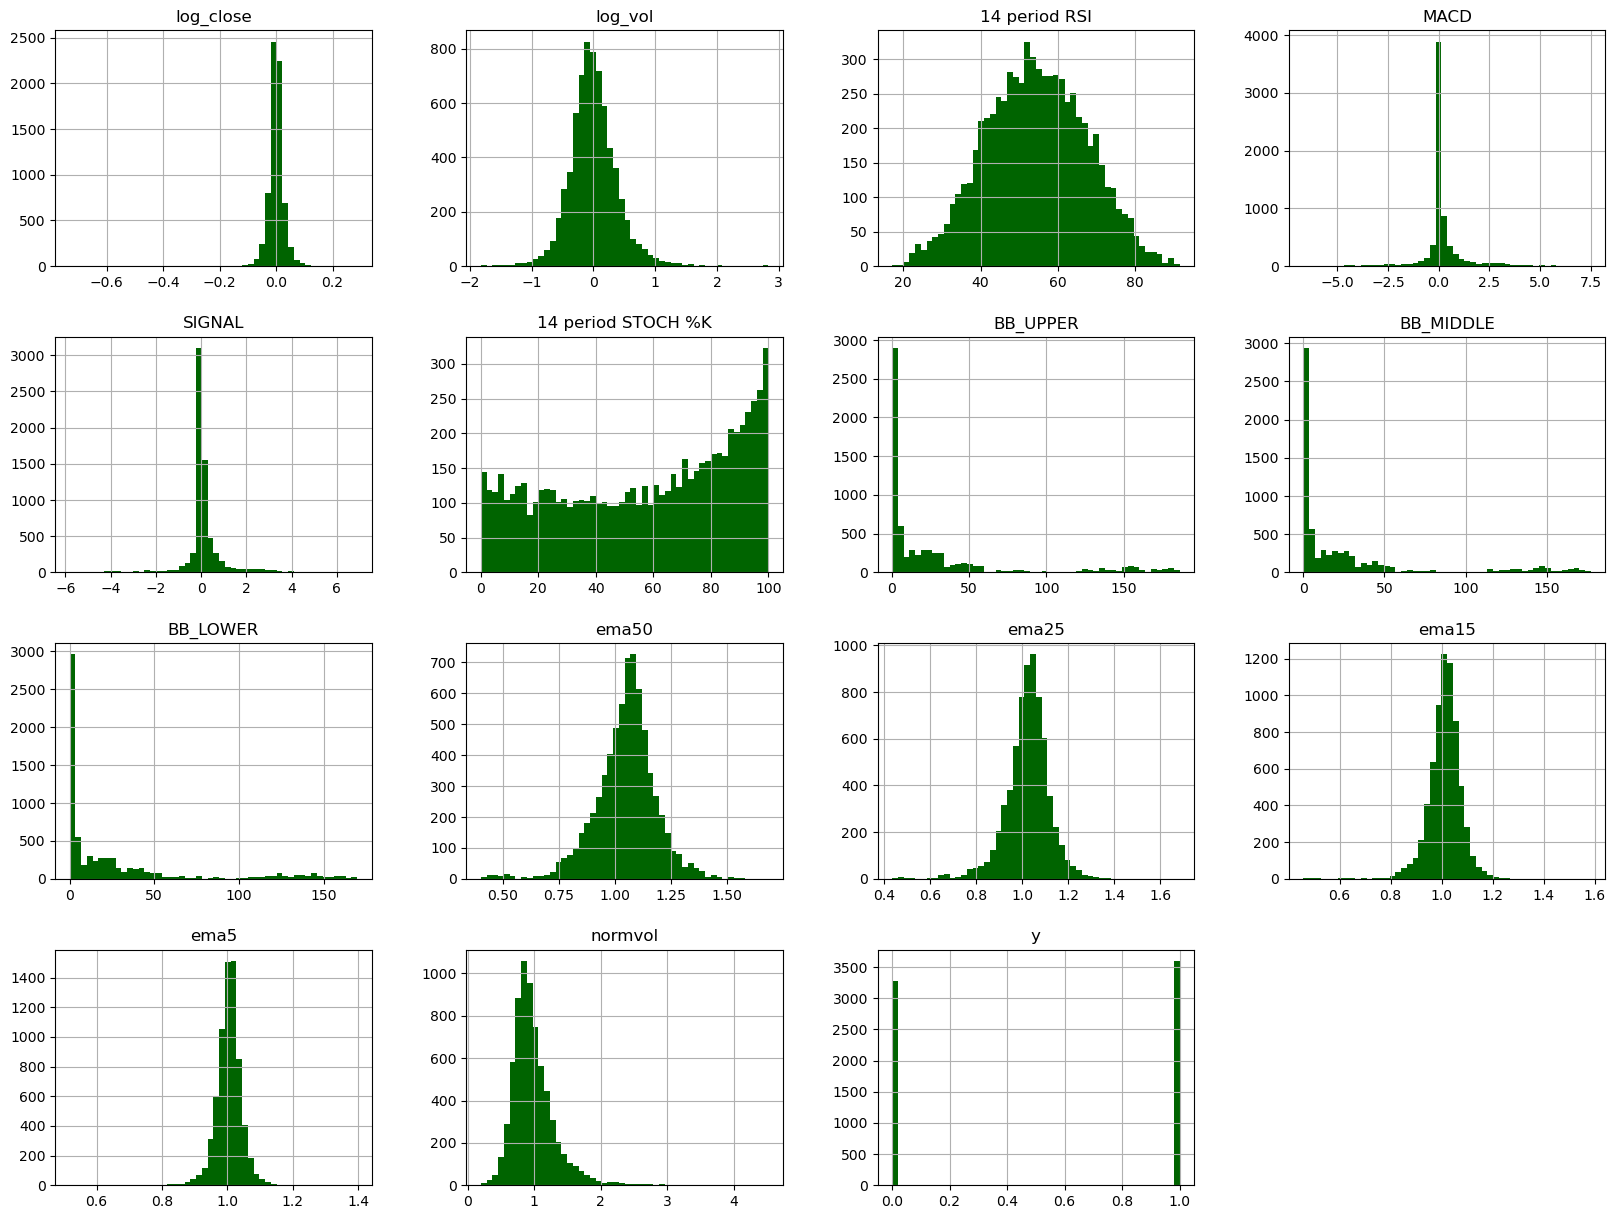

In [226]:
plot_histograms(Xy)

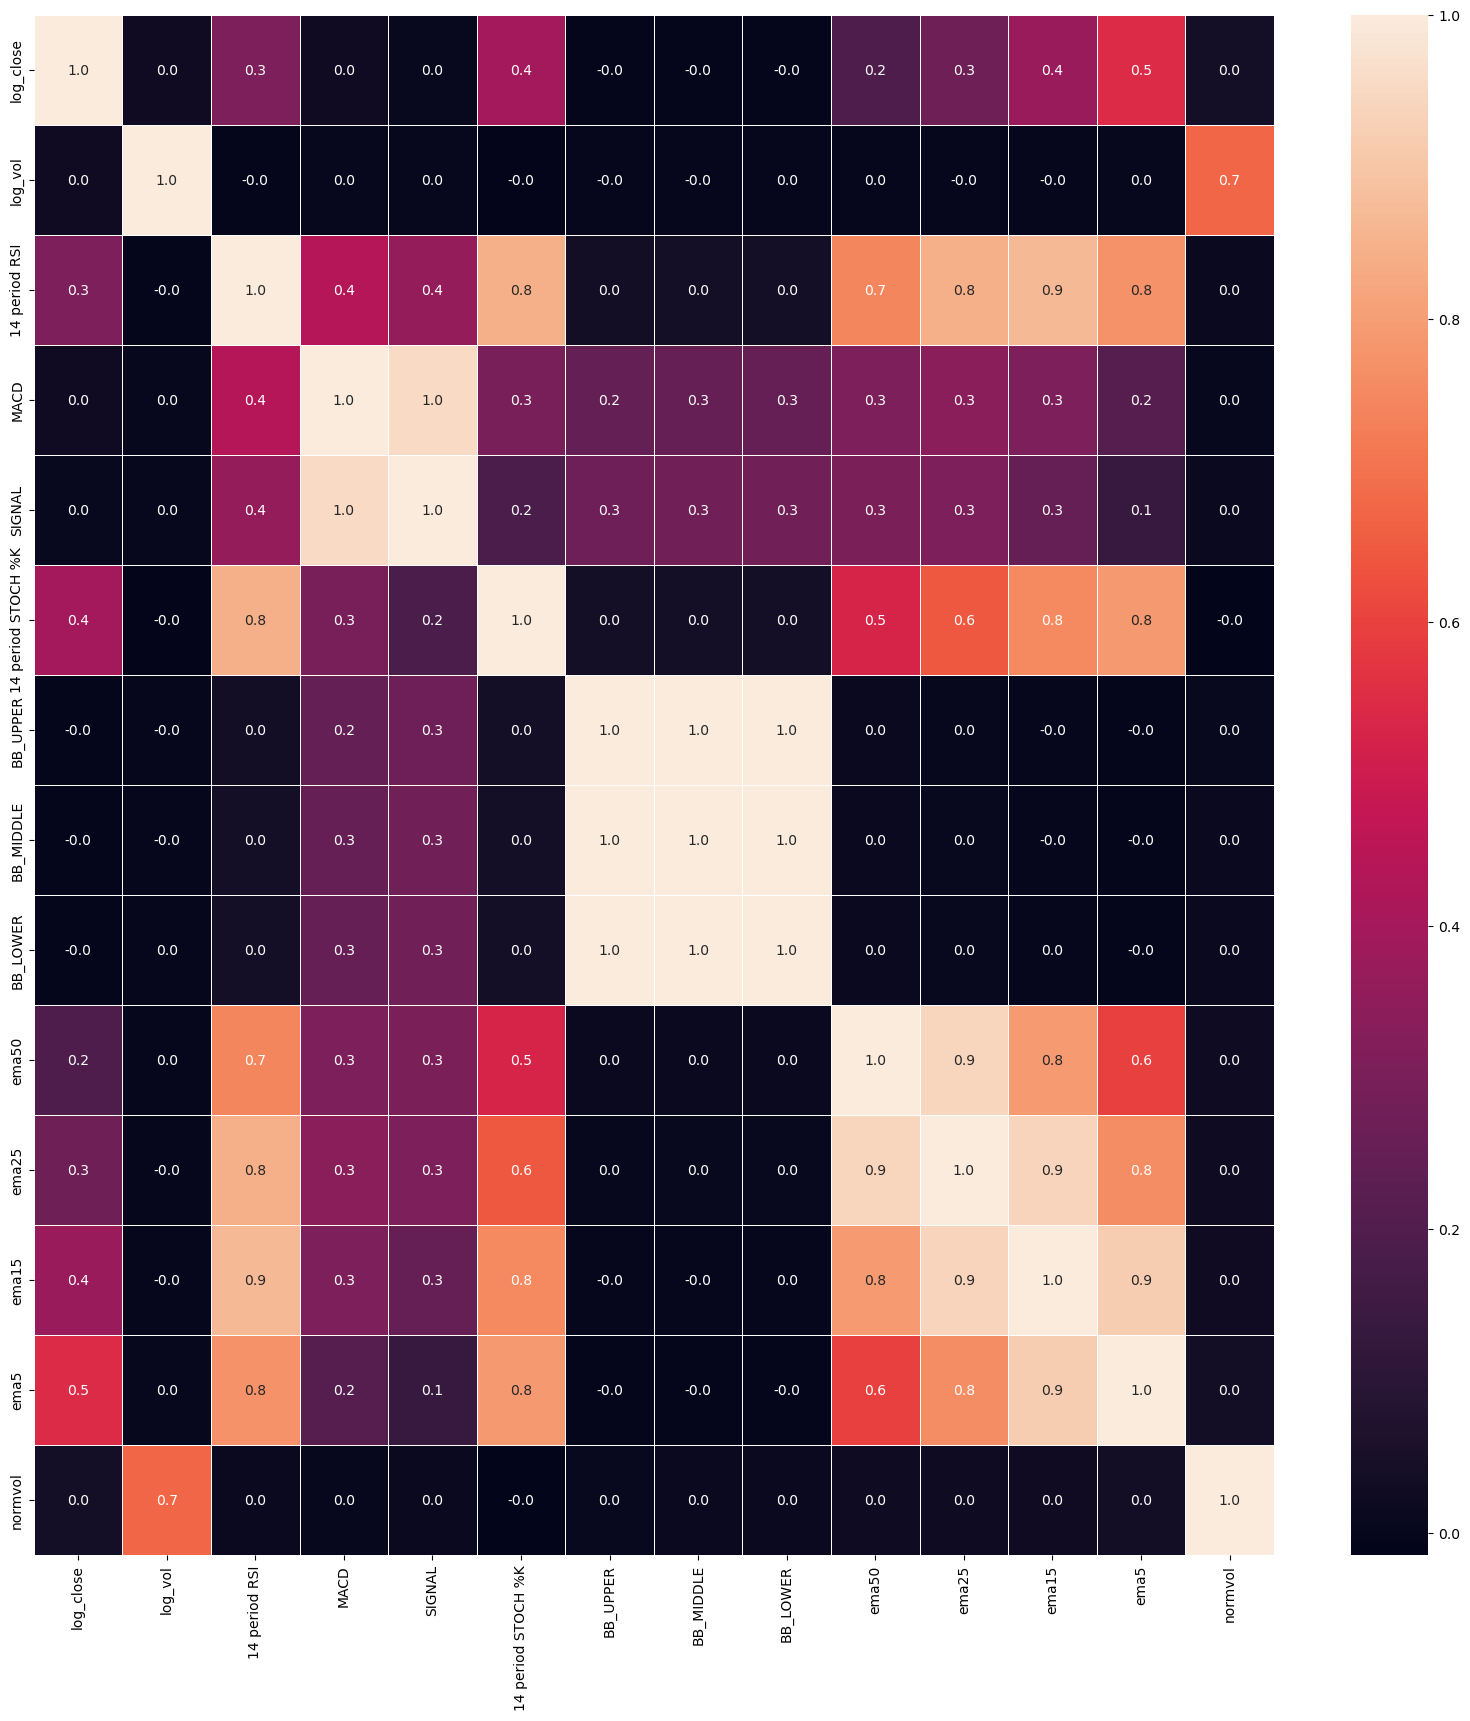

In [227]:
plot_corr_heatmap(Xy)

,close,log_close,log_vol,14 period RSI,MACD,SIGNAL,14 period STOCH %K,BB_UPPER,BB_MIDDLE,BB_LOWER,ema50,ema25,ema15,ema5,normvol,y
Date,,,,,,,,,,,,,,,,
1996-02-26,0.263393,-0.012631,-0.381864,56.442795,0.001944,0.000694,73.914109,0.270805,0.255329,0.239854,1.030282,1.028886,1.025644,1.016918,0.576690,0.0
1996-02-27,0.255580,-0.030112,0.231949,48.269046,0.001559,0.000869,43.476582,0.270423,0.255106,0.239789,0.999737,0.998478,0.995670,0.988986,0.762680,0.0
1996-02-28,0.247768,-0.031043,0.230952,41.757600,0.000718,0.000838,13.042946,0.270106,0.255301,0.240497,0.970840,0.970027,0.968363,0.965516,0.967255,0.0
1996-02-29,0.245536,-0.009049,-0.509614,40.093428,-0.000094,0.000651,8.333023,0.270195,0.255246,0.240297,0.964053,0.963703,0.963194,0.963861,0.625393,0.0
1996-03-01,0.239955,-0.022992,0.716632,36.207747,-0.001108,0.000297,6.896125,0.271009,0.254576,0.238143,0.944974,0.945268,0.946307,0.951273,1.222621,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-07,177.820007,-0.007786,-0.045812,61.248905,2.949586,2.853783,50.589097,181.339836,175.257001,169.174167,1.094353,1.050331,1.019955,1.002873,0.891997,1.0
2023-06-08,180.570007,0.015347,-0.209929,66.571016,3.008964,2.884819,69.646626,182.074346,175.607502,169.140658,1.108858,1.063850,1.032890,1.015272,0.758077,1.0
2023-06-09,180.960007,0.002157,-0.027134,67.257805,3.052306,2.918317,72.349326,182.792804,175.968002,169.143200,1.108834,1.063442,1.032332,1.014512,0.771501,1.0


In [221]:
import numpy as np
from sklearn.model_selection import train_test_split
X = Xy.iloc[:, 1:-1]
y = Xy.iloc[:,-1]

scaler = StandardScaler()
X_scaled = np.array(scaler.fit_transform(X))
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train = X_reshaped[:int(X_reshaped.shape[0]*.8), :]
y_train =  y[:int(X_reshaped.shape[0]*.8)]

X_test = X_reshaped[int(X_reshaped.shape[0]*.8):, :]
y_test = y[int(X_reshaped.shape[0]*.8):]

# X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2)
# X_train.shape, y_train.shape

In [220]:
y_train

Date
2014-03-14    1.0
2005-11-15    1.0
2023-02-06    1.0
2000-04-04    1.0
2017-12-19    0.0
             ... 
2017-07-27    0.0
2013-04-05    1.0
2008-11-03    1.0
2002-04-02    0.0
2003-06-17    1.0
Name: y, Length: 5497, dtype: float64

In [240]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape=(X_train.shape[1], 1), activation='relu',return_sequences=False))
lstm.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.01)
lstm.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
lstm.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 32)                4352      
                                                                 
 dense_17 (Dense)            (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


In [241]:
history = lstm.fit(X_train, y_train, epochs=10, batch_size=1)

Epoch 1/10
5497/5497 [==============================] - 11s 2ms/step - loss: 2.7943 - accuracy: 0.5094
Epoch 2/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6979 - accuracy: 0.5094
Epoch 3/10
5497/5497 [==============================] - 9s 2ms/step - loss: 0.6955 - accuracy: 0.5092
Epoch 4/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6948 - accuracy: 0.5156
Epoch 5/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6944 - accuracy: 0.5116
Epoch 6/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6938 - accuracy: 0.5163
Epoch 7/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.8081 - accuracy: 0.5121
Epoch 8/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6959 - accuracy: 0.5015
Epoch 9/10
5497/5497 [==============================] - 10s 2ms/step - loss: 0.6941 - accuracy: 0.5096
Epoch 10/10
5497/5497 [==============================] - 10s 2ms/step - lo

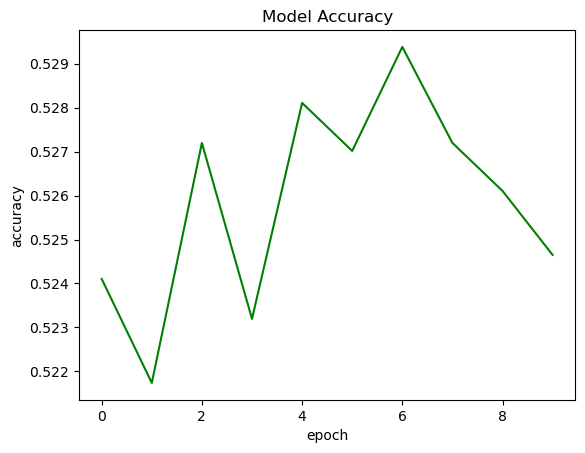

In [235]:
plt.plot(history.history['accuracy'], color='green')
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

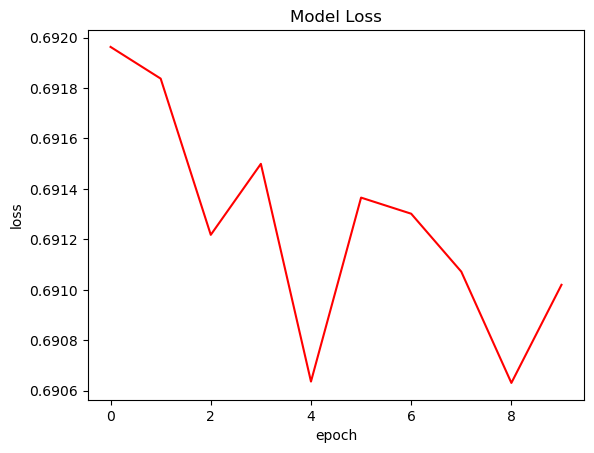

In [236]:
plt.plot(history.history['loss'], color='red')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [231]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)
scores = lstm.evaluate(X_test, y_test, verbose=0)
scores[1]

0.5338181853294373